# Classifier Based on the Urysohn's Lemma of Topology

## Loading useful libraries

In [1]:
import pandas as pd, numpy as np
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import joblib

np.random.seed(seed=42)

import warnings
warnings.filterwarnings("ignore")

/home/ernesto/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


# Separating Function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


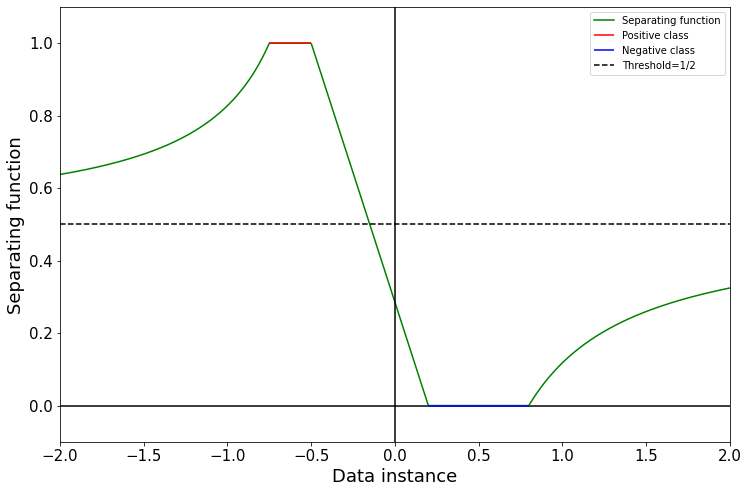

In [2]:
def distance_to_point_and_interval(x0, interval):
    closest_point = np.clip(x0, interval[0], interval[1])
    return np.linalg.norm(np.array([closest_point, 0]) - np.array([x0, 0]))

def distance_set(x0, interval):
    if interval[0] <= x0 <= interval[1]:
        return 0
    else:
        return distance_to_point_and_interval(x0, interval)

def separating_function(x, interval_a, interval_b):
    distance_b = distance_set(x, interval_b)
    distance_a = distance_set(x, interval_a)
    return distance_b / (distance_a + distance_b)

def step_function(x, interval):
    return 1 if interval[0] <= x <= interval[1] else complex(0, 1)

# Define intervals
interval_A, y_A = (-0.75, -0.5), 1
interval_B, y_B = (0.2, 0.8), 0

# Generate x values
x_values = np.linspace(-2, 2, 1000)

# Compute functions
separating_values = [separating_function(x, interval_A, interval_B) for x in x_values]
step_A_values = [step_function(x, interval_A).real for x in x_values]
step_B_values = [1 - step_function(x, interval_B).real for x in x_values]
half_values = [0.5] * len(x_values)

fig, ax = plt.subplots(figsize=(12, 8))
# Plot constant segment
ax.hlines(y_B, xmin=min(x_values), xmax=max(x_values), color='k')
# Plotting
ax.plot(x_values, separating_values, label='Separating function', color='green')
# Plot constant segment for interval_A
ax.hlines(y_A, xmin=interval_A[0], xmax=interval_A[1], color='red', label='Positive class')
# Plot constant segment for interval_B
ax.hlines(y_B, xmin=interval_B[0], xmax=interval_B[1], color='blue', label='Negative class')
# Plot constant vertical segment
ax.vlines(x=0, ymin=-1, ymax=1.1, color='k', linestyle='-')
ax.plot(x_values, half_values, label='Threshold=1/2', color='k', linestyle='--')

# Set labels and legend
plt.xlabel('Data instance', fontsize=18)
plt.ylabel('Separating function', fontsize=18)
plt.xlim(min(x_values),max(x_values))
plt.ylim(-0.1,1.1)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='best')

fig.savefig('Fig_00.eps', dpi=700,bbox_inches='tight')

# Show the plot
plt.show()

## Class definition

In [3]:
class UrysohnClassifier:
    def __init__(self, distance_metric = 2, epsilon = 0.0):
        self.distance_metric = distance_metric
        self.epsilon = epsilon
        self.n_permutations = 100
    
    def get_params(self, deep=True):
        return {"distance_metric": self.distance_metric, "epsilon": self.epsilon}

    def set_params(self, **params):
        self.distance_metric = params["distance_metric"]
        self.epsilon = params["epsilon"]
        return self
     
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    def predict_proba(self, X, y=None):
        y_pred = []
        self.class_neg, self.class_pos = self.X_train[self.y_train==0], self.X_train[self.y_train==1]
        dist_neg, dist_pos = X[:,np.newaxis,:] - self.class_neg, X[:,np.newaxis,:] - self.class_pos
        dist_neg = np.linalg.norm(dist_neg,ord=self.distance_metric,axis=2)
        dist_pos = np.linalg.norm(dist_pos,ord=self.distance_metric,axis=2)
        dist_neg, dist_pos = np.min(dist_neg,axis=1), np.min(dist_pos,axis=1)
        # Urysohn separating function
        probability_neg = dist_pos/(dist_neg + dist_pos + self.epsilon)
        y_pred = [[el, 1-el] for el in probability_neg]
        return y_pred

    def predict(self, X, y=None):
        y_pred = self.predict_proba(X)
        result = [np.argmax(el) for el in y_pred]
        return result

    def score(self,X,y):
        y_prob = self.predict_proba(X)
        y_prob = [el[1] for el in y_prob]
        return roc_auc_score(y, y_prob)
    
    
    def permutation_importance(self, X, y, predictor_columns):
        # Builds a dataframe with the column names
        df_valid = pd.DataFrame(X,columns=predictor_columns)
        # Create an empty DataFrame to store results
        results_df = pd.DataFrame(columns=['Predictor', 'Avg_AUC', 'Std_AUC'])
        for predictor in df_valid.columns:
            scores = []  # To store accuracy scores for each permutation
            for _ in range(self.n_permutations):
                # Create a copy of the original DataFrame to perform permutations
                df_permuted = df_valid.copy()
                # Permute the values in the selected predictor column
                df_permuted[predictor] = np.random.permutation(df_permuted[predictor])
                # Split the permuted data into predictor and target
                X_permuted = df_permuted[predictor_columns]
                # Predict using the pre-trained KNN classifier
                y_pred = self.predict(X_permuted.values)
                # Calculate accuracy for the permuted data
                score = accuracy_score(y, y_pred)
                scores.append(1.0-score)
            # Calculate average and standard deviation of AUC scores
            avg_score = np.mean(scores)
            std_score = np.std(scores)
            # Append the results to the DataFrame
            results_df = results_df.append({'Predictor': predictor, 'Permutation Importance': avg_score, 'Error': std_score}, ignore_index=True)
        # Returns results_df for further analysis
        return results_df



## Loading the diabetes and breast cancer datasets to test a binary classification

In [4]:
# Load the Breast Cancer dataset
breast_cancer = load_breast_cancer()
breast_cancer_features = breast_cancer.feature_names
# Select predictors and target variables
X_cancer, y_cancer = breast_cancer.data, breast_cancer.target


# Load the Chronic Kidney Desease dataset
kidney_dataset = pd.read_csv('chronic_kidney_desease_dataset.csv')
kidney_dataset_features = list(kidney_dataset.columns)
# Select predictors and target variables
X_kidney, y_kidney = kidney_dataset.drop(['Patient','LABEL'],axis=1).values, kidney_dataset['LABEL'].values


# Load the Banknote Authentication dataset
banknote_dataset = pd.read_csv('data_banknote_authentication.txt')
banknote_dataset.columns = ['Variance','Skewness','Kurtosis', 'Entropy','Class']
banknote_dataset_features = banknote_dataset.columns
# Select predictors and target variables
X_bank, y_bank = banknote_dataset.drop('Class',axis=1).values, banknote_dataset['Class'].values

# Performance with different datasets

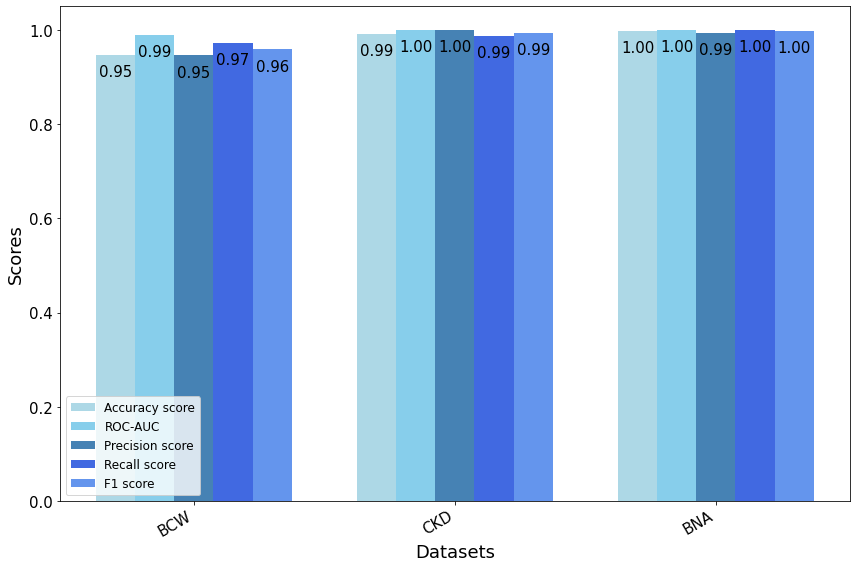

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [5]:
labels = ['BCW', 'CKD', 'BNA']

# Initialize Urysohn's classifier
ury = UrysohnClassifier(distance_metric = 1)  # You can change the metric power

# Lists to store accuracy and AUC values
accuracy_scores, auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

# Split the dataset into train and test sets and evaluate KNN
for X, y, label in zip([X_cancer, X_kidney, X_bank],
                       [y_cancer, y_kidney, y_bank],
                       labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fit Urysohn's model
    ury.fit(X_train, y_train)

    # Make predictions
    y_pred = ury.predict(X_test)
    y_prob = ury.predict_proba(X_test)
    y_prob = [el[1] for el in y_prob]

    # Calculate accuracy and AUC
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(accuracy)
    auc_scores.append(roc_auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Create the bar plot
x_pos = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))
accuracy_bars = ax.bar(x_pos, accuracy_scores, width, label='Accuracy score', align='center', color='#ADD8E6')
auc_bars = ax.bar(x_pos + width, auc_scores, width, label='ROC-AUC', align='center', color='#87CEEB')
precision_bars = ax.bar(x_pos + 2*width, precision_scores, width, label='Precision score', align='center', color='#4682B4')
recall_bars = ax.bar(x_pos + 3*width, recall_scores, width, label='Recall score', align='center', color='#4169E1')
f1_bars = ax.bar(x_pos + 4*width, f1_scores, width, label='F1 score', align='center', color='cornflowerblue')

ax.set_xlabel('Datasets', fontsize=18)
ax.set_ylabel('Scores', fontsize=18)
ax.set_xticks(x_pos + 4 * width / 2)
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rc('legend', fontsize=12)
ax.legend(loc='lower left')

# Add values of accuracy and AUC inside the bars (a bit lower)
for i in range(len(x_pos)):
    ax.text(x_pos[i], accuracy_scores[i] - 0.02, f'{accuracy_scores[i]:.2f}', ha='center', va='top', fontsize=15)
    ax.text(x_pos[i] + width, auc_scores[i] - 0.02, f'{auc_scores[i]:.2f}', ha='center', va='top', fontsize=15)
    ax.text(x_pos[i] + 2*width, precision_scores[i] - 0.02, f'{precision_scores[i]:.2f}', ha='center', va='top', fontsize=15)
    ax.text(x_pos[i] + 3*width, recall_scores[i] - 0.02, f'{recall_scores[i]:.2f}', ha='center', va='top', fontsize=15)
    ax.text(x_pos[i] + 4*width, f1_scores[i] - 0.02, f'{f1_scores[i]:.2f}', ha='center', va='top', fontsize=15)

plt.tight_layout()

# Show the plot
plt.show()
fig.savefig('Fig_01.eps', dpi=700,bbox_inches='tight')

## Training the Urysohn's classifier and calculating metrics

Classification report train sample
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       106
          1       1.00      1.00      1.00       174

avg / total       1.00      1.00      1.00       280

Confusion matrix train sample


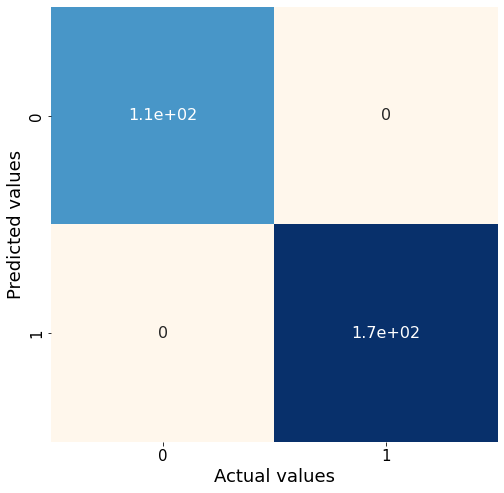

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_kidney, y_kidney, test_size=0.3, random_state=42)

ury = UrysohnClassifier(distance_metric=1)
ury.fit(X_train, y_train)
y_preds = ury.predict(X_train)

print("Classification report train sample")
print(classification_report(y_train,y_preds))

print("Confusion matrix train sample")
cf_matrix = confusion_matrix(y_train,y_preds)
vmin = np.min(cf_matrix)
vmax = np.max(cf_matrix)
off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)
fig = plt.figure(figsize=(8, 8))
sns.heatmap(cf_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax, cbar=False, annot_kws={"size": 16})
sns.heatmap(cf_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar=False, annot_kws={"size": 16})
plt.xlabel('Actual values', fontsize = 18) # x-axis label with fontsize 18
plt.ylabel('Predicted values', fontsize = 18) # y-axis label with fontsize 18
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

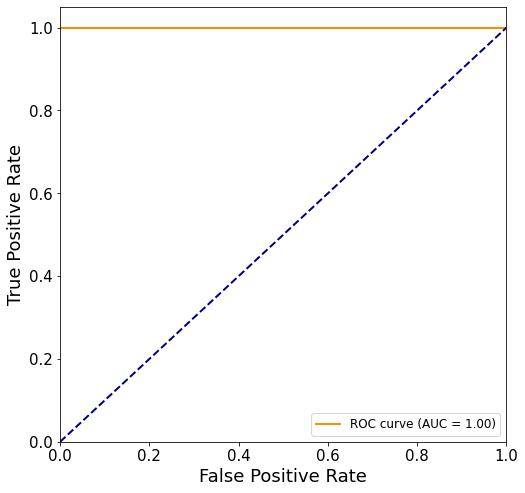

In [7]:
# Predict probabilities for the positive class (class 1) on the test set
y_pred_proba = ury.predict_proba(X_train)
y_pred_proba = [el[1] for el in y_pred_proba]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig = plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18) # x-axis label with fontsize 18
plt.ylabel('True Positive Rate', fontsize = 18) # y-axis label with fontsize 18
plt.legend(loc='lower right')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## Testing the Urysohn's classifier and calculating metrics

Classification report test sample
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        44
          1       1.00      0.99      0.99        76

avg / total       0.99      0.99      0.99       120

Confusion matrix test sample


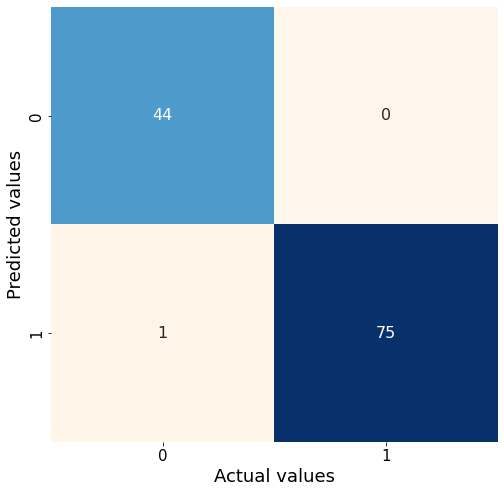

In [8]:
y_preds = ury.predict(X_test)

print("Classification report test sample")
print(classification_report(y_test,y_preds))

print("Confusion matrix test sample")
cf_matrix = confusion_matrix(y_test,y_preds)
vmin = np.min(cf_matrix)
vmax = np.max(cf_matrix)
off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)
fig = plt.figure(figsize=(8, 8))
sns.heatmap(cf_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax, cbar=False, annot_kws={"size": 16})
sns.heatmap(cf_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar=False, annot_kws={"size": 16})
plt.xlabel('Actual values', fontsize = 18) # x-axis label with fontsize 18
plt.ylabel('Predicted values', fontsize = 18) # y-axis label with fontsize 18
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()
fig.savefig('Fig_02.eps', dpi=700,bbox_inches='tight')

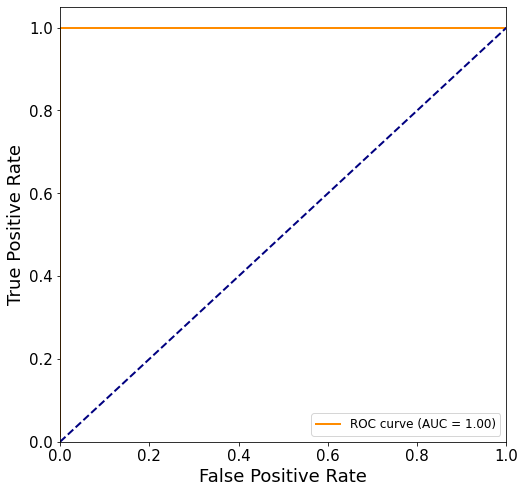

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
# Predict probabilities for the positive class (class 1) on the test set
y_pred_proba = ury.predict_proba(X_test)
y_pred_proba = [el[1] for el in y_pred_proba]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig = plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()
fig.savefig('Fig_03.eps', dpi=700,bbox_inches='tight')

## Feature Importance on the test subsample

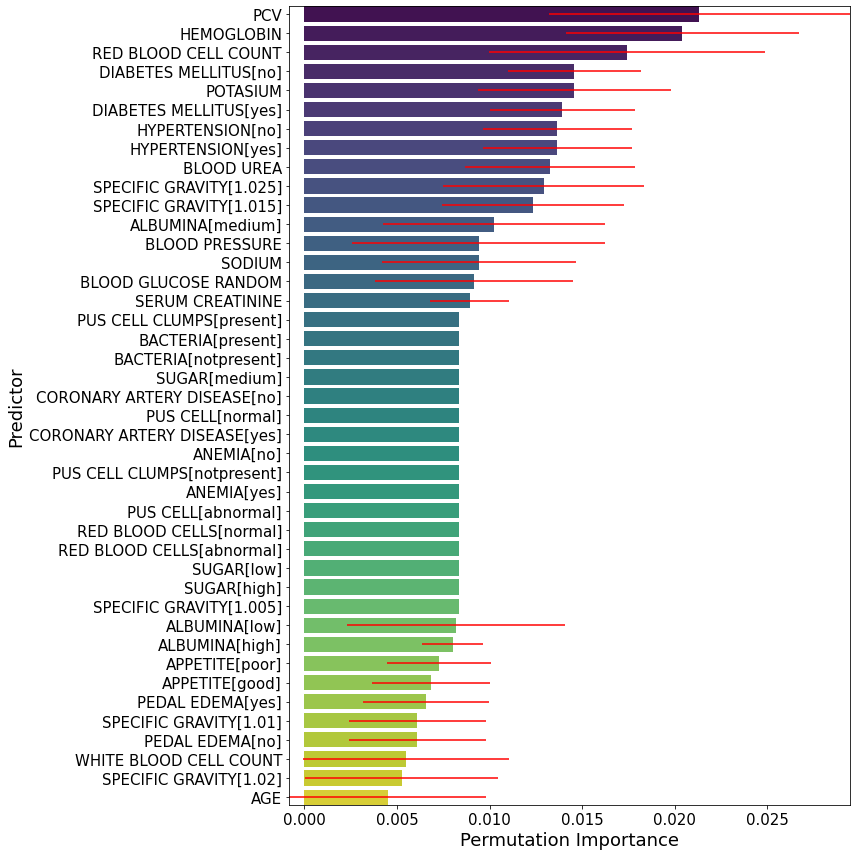

In [10]:
col_names = ['AGE', 'BLOOD PRESSURE', 'BLOOD GLUCOSE RANDOM', 'BLOOD UREA', 'SERUM CREATININE', 'SODIUM',
             'POTASIUM', 'HEMOGLOBIN', 'PCV', 'WHITE BLOOD CELL COUNT', 'RED BLOOD CELL COUNT',
             'SPECIFIC GRAVITY[1.005]', 'SPECIFIC GRAVITY[1.01]', 'SPECIFIC GRAVITY[1.015]',
             'SPECIFIC GRAVITY[1.02]', 'SPECIFIC GRAVITY[1.025]', 'ALBUMINA[high]', 'ALBUMINA[low]',
             'ALBUMINA[medium]', 'SUGAR[high]', 'SUGAR[low]', 'SUGAR[medium]', 'RED BLOOD CELLS[abnormal]',
             'RED BLOOD CELLS[normal]', 'PUS CELL[abnormal]', 'PUS CELL[normal]', 'PUS CELL CLUMPS[notpresent]',
             'PUS CELL CLUMPS[present]', 'BACTERIA[notpresent]', 'BACTERIA[present]', 'HYPERTENSION[no]',
             'HYPERTENSION[yes]', 'DIABETES MELLITUS[no]', 'DIABETES MELLITUS[yes]', 'CORONARY ARTERY DISEASE[no]',
             'CORONARY ARTERY DISEASE[yes]', 'APPETITE[good]', 'APPETITE[poor]', 'PEDAL EDEMA[no]',
             'PEDAL EDEMA[yes]', 'ANEMIA[no]', 'ANEMIA[yes]']
results_df = ury.permutation_importance(X_test,y_test,col_names)

df = results_df.copy()

# Sort the DataFrame by 'Avg_AUC' in descending order
df = df.sort_values(by='Permutation Importance', ascending=False)

# Create the horizontal bar plot with error bars
fig, ax = plt.subplots(figsize=(12, 12))
# sns.set(style="whitegrid")
sns.barplot(x="Permutation Importance", y="Predictor", data=df[df['Permutation Importance']>0],
            estimator=np.mean, ci=85, orient="h", palette="viridis")

# Add error bars using Std_AUC
for i, bar in enumerate(plt.gca().patches):
    x = bar.get_x() + bar.get_width() # Adjust the position of the error bars
    y = bar.get_y() + bar.get_height() / 2
    std_auc = (df['Error']).iloc[i]
    plt.errorbar(x, y, xerr=std_auc, fmt=' ', color='red')

plt.xlabel('Permutation Importance', fontsize=18)
plt.ylabel('Predictor', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
ax.margins(x=0,y=0)
plt.tight_layout()
plt.show()
fig.savefig('Fig_04.eps', dpi=700,bbox_inches='tight')

# Sensitivity analysis

## Sensitivity to randomness in train/test subsamples

In [11]:
acc_train, acc_tests = [], []
roc_auc_train, roc_auc_test = [], []

iterations = range(1,201) 

for el in iterations:
    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X_kidney, y_kidney, test_size=0.3, random_state=42)
    # Instance of the model
    ury = UrysohnClassifier(distance_metric=2)
    # Trains the model
    ury.fit(X_train, y_train)
    # Makes predictions on the train and test subsamples
    y_preds_train = ury.predict(X_train)
    y_preds_tests = ury.predict(X_test)
    # Computes the accuracy on the train and test subsamples
    acc_train.append(accuracy_score(y_train,y_preds_train))
    acc_tests.append(accuracy_score(y_test,y_preds_tests))
    # Computes the AUC on the train and test subsamples
    fpr_train, tpr_train, _ = roc_curve(y_train, y_preds_train)
    roc_auc_train.append(auc(fpr_train, tpr_train))
    fpr_test, tpr_test, _ = roc_curve(y_test, y_preds_tests)
    roc_auc_test.append(auc(fpr_test, tpr_test))

### Accuracy goal

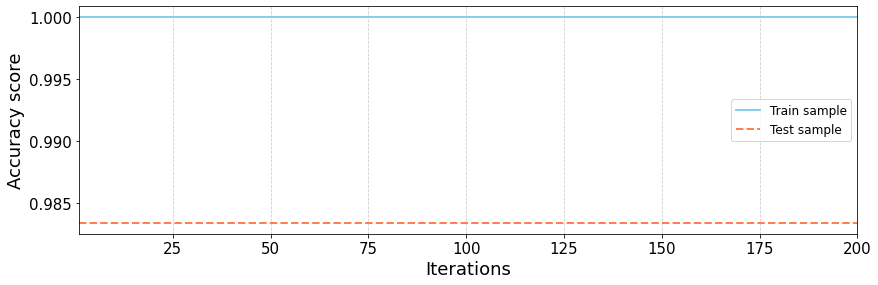

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the first array as a horizontal line with a fancy color
ax.plot(iterations, acc_train, label='Train sample', color='skyblue', linestyle='-', linewidth=2)

# Plot the second array as a horizontal line with a different fancy color
ax.plot(iterations, acc_tests, label='Test sample', color='coral', linestyle='--', linewidth=2)

# Add labels, legend, and title
ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('Accuracy score', fontsize=18)
ax.legend()

# Show the plot
plt.tight_layout()
plt.xlim(min(iterations),max(iterations))
plt.grid(axis='x', linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()
fig.savefig('Fig_05.eps', dpi=700,bbox_inches='tight')

### AUC

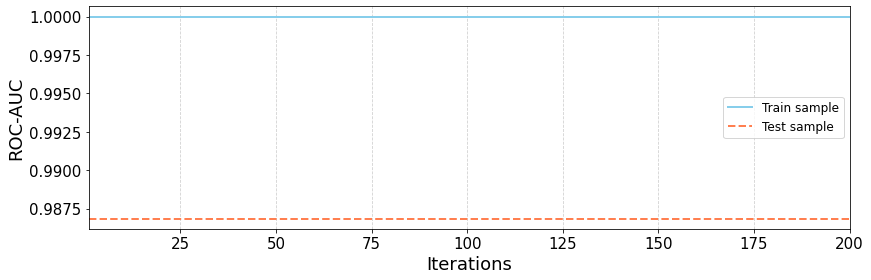

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the first array as a horizontal line with a fancy color
ax.plot(iterations, roc_auc_train, label='Train sample', color='skyblue', linestyle='-', linewidth=2)

# Plot the second array as a horizontal line with a different fancy color
ax.plot(iterations, roc_auc_test, label='Test sample', color='coral', linestyle='--', linewidth=2)

# Add labels, legend, and title
ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('ROC-AUC', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()

# Show the plot
plt.tight_layout()
plt.xlim(min(iterations),max(iterations))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
fig.savefig('Fig_06.eps', dpi=700,bbox_inches='tight')

## Sensitivity to the metric type

In [14]:
acc_train, acc_tests = [], []
roc_auc_train, roc_auc_test = [], []

p_metric = range(1,10)

for el in p_metric:
    X_train, X_test, y_train, y_test = train_test_split(X_kidney, y_kidney, test_size=0.3, random_state=42)
    ury = UrysohnClassifier(distance_metric=el)
    ury.fit(X_train, y_train)
    y_preds_train = ury.predict(X_train)
    y_preds_tests = ury.predict(X_test)
    #Computes the accuracy goal on the train and test subsamples
    acc_train.append(accuracy_score(y_train,y_preds_train))
    acc_tests.append(accuracy_score(y_test,y_preds_tests))
    # Computes the AUC on the train and test subsamples
    fpr_train, tpr_train, _ = roc_curve(y_train, y_preds_train)
    roc_auc_train.append(auc(fpr_train, tpr_train))
    fpr_test, tpr_test, _ = roc_curve(y_test, y_preds_tests)
    roc_auc_test.append(auc(fpr_test, tpr_test))

### Accuracy goal

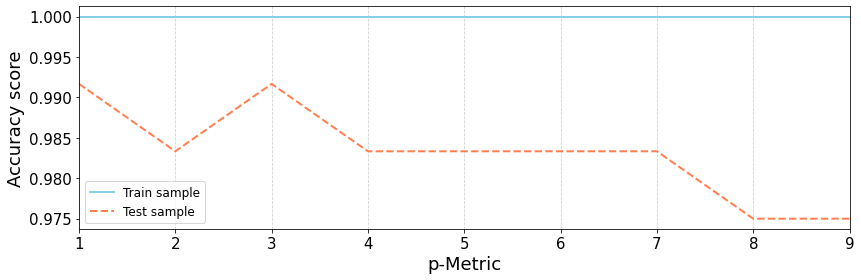

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the first array as a horizontal line with a fancy color
ax.plot(p_metric, acc_train, label='Train sample', color='skyblue', linestyle='-', linewidth=2)

# Plot the second array as a horizontal line with a different fancy color
ax.plot(p_metric, acc_tests, label='Test sample', color='coral', linestyle='--', linewidth=2)

# Add labels, legend, and title
ax.set_xlabel('p-Metric', fontsize=18)
ax.set_ylabel('Accuracy score', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()

# Show the plot
plt.tight_layout()
plt.xlim(min(p_metric),max(p_metric))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
fig.savefig('Fig_07.eps', dpi=700,bbox_inches='tight')

### AUC

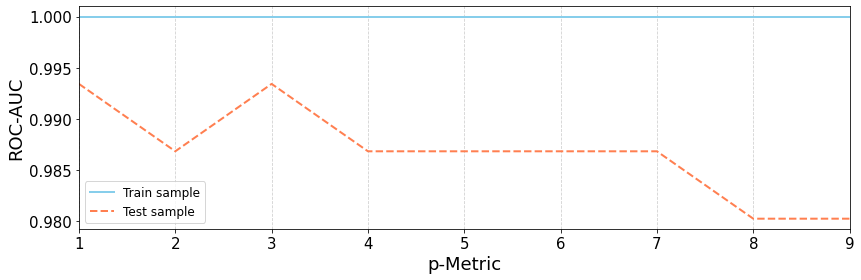

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the first array as a horizontal line with a fancy color
ax.plot(p_metric, roc_auc_train, label='Train sample', color='skyblue', linestyle='-', linewidth=2)

# Plot the second array as a horizontal line with a different fancy color
ax.plot(p_metric, roc_auc_test, label='Test sample', color='coral', linestyle='--', linewidth=2)

# Add labels, legend, and title
ax.set_xlabel('p-Metric', fontsize=18)
ax.set_ylabel('ROC-AUC', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()

# Show the plot
plt.tight_layout()
plt.xlim(min(p_metric),max(p_metric))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
fig.savefig('Fig_08.eps', dpi=700,bbox_inches='tight')

## Sensitivity to class imbalance

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Define a range of imbalance ratios (from 10% to 90% minority class)
imbalance_ratios = np.linspace(0.1, 0.9, 19)

# Initialize lists to store results
accuracy_scores_knn, auc_scores_knn = [], []
accuracy_scores_ury, auc_scores_ury = [], []

# Loop through different imbalance ratios
for imbalance_ratio in imbalance_ratios:
    # Create an imbalanced dataset by randomly undersampling the majority class
    X_train, X_test, y_train, y_test = train_test_split(X_kidney, y_kidney, test_size=0.3, random_state=42)
    minority_class_indices = np.where(y_train == 1)[0]
    majority_class_indices = np.where(y_train == 0)[0]
    num_minority_samples = int(len(minority_class_indices) * (1 - imbalance_ratio))
    random_majority_indices = np.random.choice(majority_class_indices, num_minority_samples, replace=True)
    balanced_indices = np.concatenate((minority_class_indices, random_majority_indices))
    X_train_balanced, y_train_balanced = X_train[balanced_indices], y_train[balanced_indices]

    # Train KNN and Ury classifiers on the balanced dataset
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_balanced, y_train_balanced)
    ury = UrysohnClassifier(distance_metric=1)
    ury.fit(X_train_balanced, y_train_balanced)

    # Predict on the test set
    y_pred_knn = knn.predict(X_test)
    y_pred_ury = ury.predict(X_test)

    # Calculate accuracy and AUC
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    auc_knn = roc_auc_score(y_test, y_pred_knn)
    accuracy_ury = accuracy_score(y_test, y_pred_ury)
    auc_ury = roc_auc_score(y_test, y_pred_ury)

    # Store the results
    accuracy_scores_knn.append(accuracy_knn)
    auc_scores_knn.append(auc_knn)
    accuracy_scores_ury.append(accuracy_ury)
    auc_scores_ury.append(auc_ury)

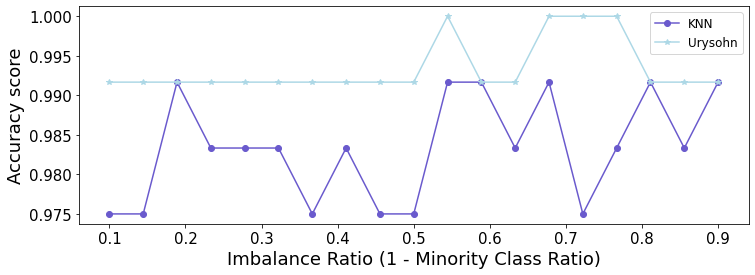

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))
# Plot the sensitivity of KNN and Ury to class imbalance
ax.plot(imbalance_ratios, accuracy_scores_knn, marker='o', label='KNN', color='slateblue')
ax.plot(imbalance_ratios, accuracy_scores_ury, marker='*', label='Urysohn',color='lightblue')
plt.xlabel('Imbalance Ratio (1 - Minority Class Ratio)', fontsize=18)
plt.ylabel('Accuracy score', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.show()
fig.savefig('Fig_09.eps', dpi=700,bbox_inches='tight')

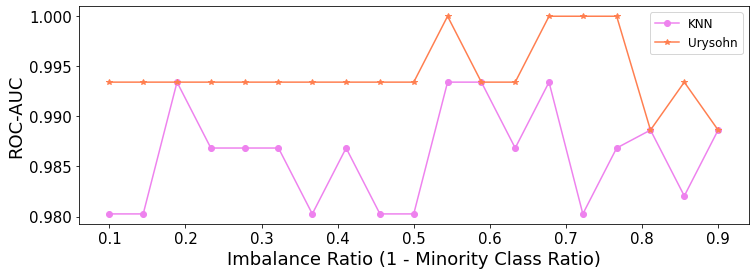

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [19]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))
# Plot the sensitivity of KNN and Ury to class imbalance
ax.plot(imbalance_ratios, auc_scores_knn, marker='o', label='KNN',color='violet')
ax.plot(imbalance_ratios, auc_scores_ury, marker='*', label='Urysohn',color='coral')
plt.xlabel('Imbalance Ratio (1 - Minority Class Ratio)', fontsize=18)
plt.ylabel('ROC-AUC', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.show()
fig.savefig('Fig_10.eps', dpi=700,bbox_inches='tight')

## Sensitivity to data clustering

In [20]:
# Initialize variables to store results
ratios = np.linspace(0.1, 1.0, 10)  # Clustering ratios from 10% to 100%
accuracies_knn, accuracies_ury = [], []

for ratio in ratios:
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_kidney, y_kidney, test_size=0.3, random_state=42)
    
    # Simulate clustering by reducing the size of the training set
    cluster_size = int(len(X_train) * ratio)
    X_train_clustered = X_train[:cluster_size]
    y_train_clustered = y_train[:cluster_size]
    
    # Create and train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_clustered, y_train_clustered)
    ury = UrysohnClassifier(distance_metric=1)
    ury.fit(X_train_clustered, y_train_clustered)
    
    # Make predictions
    y_pred_knn = knn.predict(X_test)
    y_pred_ury = ury.predict(X_test)
    
    # Calculate accuracy
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracy_ury = accuracy_score(y_test, y_pred_ury)
    
    accuracies_knn.append(accuracy_knn)
    accuracies_ury.append(accuracy_ury)

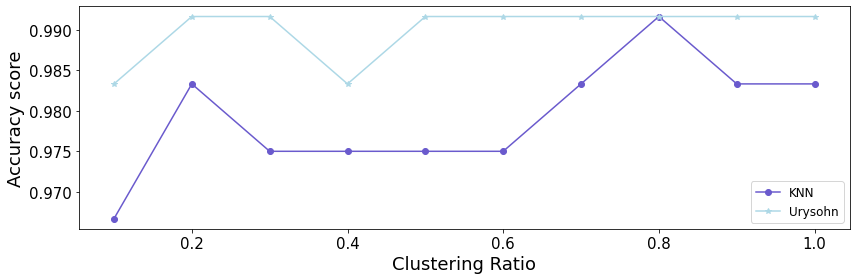

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [21]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))
# Plot the results
ax.plot(ratios, accuracies_knn, marker='o', color='slateblue', label='KNN')
ax.plot(ratios, accuracies_ury, marker='*', color='lightblue', label='Urysohn')
plt.xlabel('Clustering Ratio', fontsize=18)
plt.ylabel('Accuracy score', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('Fig_11.eps', dpi=700,bbox_inches='tight')

In [22]:
# Initialize variables to store results
ratios = np.linspace(0.1, 1.0, 10)  # Clustering ratios from 10% to 100%
auc_scores_knn, auc_scores_ury = [], []

for ratio in ratios:
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_kidney, y_kidney, test_size=0.3, random_state=42)
    
    # Simulate clustering by reducing the size of the training set
    cluster_size = int(len(X_train) * ratio)
    X_train_clustered = X_train[:cluster_size]
    y_train_clustered = y_train[:cluster_size]
    
    # Create and train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_clustered, y_train_clustered)
    ury = UrysohnClassifier(distance_metric=1)
    ury.fit(X_train_clustered, y_train_clustered)
    
    # Make predictions
    y_pred_knn = knn.predict(X_test)
    y_pred_ury = ury.predict(X_test)
    
    # Calculate AUC
    auc_knn = roc_auc_score(y_test, y_pred_knn)
    auc_ury = roc_auc_score(y_test, y_pred_ury)
    
    auc_scores_knn.append(auc_knn)
    auc_scores_ury.append(auc_ury)

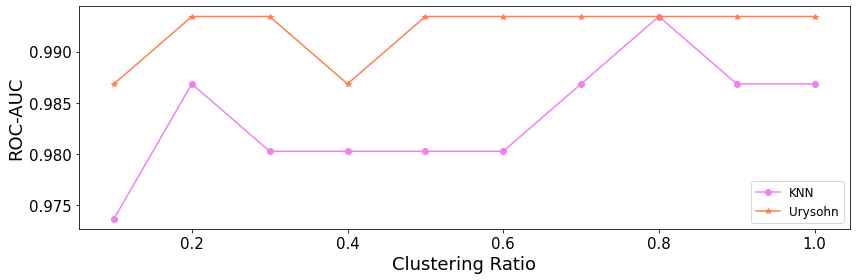

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
# Plot the results
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ratios, auc_scores_knn, marker='o', color='violet', label='KNN')
ax.plot(ratios, auc_scores_ury, marker='*', color='coral', label='Urysohn')
plt.xlabel('Clustering Ratio', fontsize=18)
plt.ylabel('ROC-AUC', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('Fig_12.eps', dpi=700,bbox_inches='tight')

# Bias-Variance Trade-off

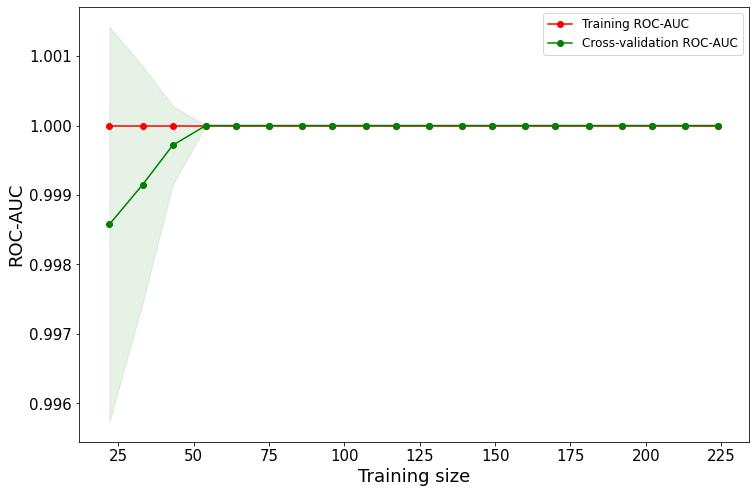

In [24]:
from sklearn.model_selection import learning_curve

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 20)):
    plt.figure(figsize=(12,8))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training size",fontsize=18)
    plt.ylabel("ROC-AUC",fontsize=18)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # Plot bias-variance trade-off curves
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training ROC-AUC")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation ROC-AUC")
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(loc="best")
    return plt

# Create a random forest classifier
classifier = UrysohnClassifier(distance_metric=1)

# Plot learning curve
plot_learning_curve(classifier, X_train, y_train, cv=5, n_jobs=-1)

plt.show()


- As the training set size increases, we see that the training score increases and the cross-validation score remains relatively stable and close to the training score. The model is likely capturing the underlying patterns well, which suggests a good fit with very low bias.

- As the training set size increases, we see that the gap between the training and cross-validation scores decreases and both scores converge, therefore suggesting that the model is generalizing well to new data, which indicates a very low variance.


- Learning Curve Patterns:
    - Converging Curves: If both the training and cross-validation scores are increasing and converging, it indicates a well-fitting model with good generalization.
    - Diverging Curves: If the training score increases while the cross-validation score decreases or remains stagnant, it suggests overfitting.
    - Stable Curves: If both scores remain stable and low, it suggests underfitting.

